## Стратегия взаимодействия пользователей в фитнес-зале

#### Исследование поведенческой модели поситителей фитнес-центра на основе собранных данных. 

In [1]:
# Импортируем необходимые модули для работы с данными
import pandas as pd
import numpy as np
import seaborn as sns


from scipy import stats as st
from datetime import timedelta
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
#Загрузим интересующиий нас датасет
df = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# Посмотрим на содержимое
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,13,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,2,3,1.113884,1.120078,0


In [4]:
# Не нравятся столбцы
# Приведем к нижнему регистру название столбцов
new_columns = []

for call in np.array(df.columns):
    new_columns.append(call.lower())
    
df.columns = new_columns

In [5]:
# Посмотрим на содержимое по типам и количествам пропусков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null int64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(3), int64(11)
memory usage: 437.6 KB


In [6]:
# Посмотрим на отчет по основным статистическим показателям
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,5.011500,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,3.899573,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,2.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,2.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,7.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,13.000000,31.000000,6.023668,6.146783,1.000000


In [7]:
# Посмотрим чем отличаются средние показатели по двум разделенным группам, те кто уйдет и те кто продолжит абонемент
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.888397,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,2.582469,0.990575,1.474995,1.044546


Люди которые уходят.

 * Живут дальше.
 * Чаще всего приходят не по партнерской программе.
 * Приходят персонально а не по ации "Приведи друга".
 * Период взаимодействия с этими людьми намного меньше чем с устаявшимися клиентами.
 * Они меньше посещают групповые занятия.
 * Эта немного младшая возрастная группа пользователей.
 
Не буду дальше продолжать так как все показатели меньше чем у людей которые собираются продолжить свой абонемент
Из основных могу выделить. Конечно возраст - очень важный показатель хоть и отличается не сильно, партнерская программа или акция "приведи друга" - по этой программе можно сказать, что люди которые ходят по этой программе имеют "соревновательный эффект" между собой, так как скорее всего это могут быть коллеги и друзья.
Еще конечно важный показатель период сколько времени состоят отношения между человеком и организаций, но это уже другой показатель и следствие предъидущих показателей. Показатель который нам тоже необходим для анализа но для первоначального привлечения совсем не нужен.

[2939, 1061]
Круговая диаграмма показателей факта оттока в текущем месяце


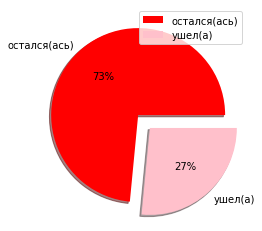

In [8]:
# Посмотри какой процент вообще из всех анкет людей которые не захотели продливать абоненемент.

size = list(df['churn'].value_counts())
print(size)
colors = ['red', 'pink']
labels = "остался(ась)", "ушел(а)"
explode = [0, 0.2]

print('Круговая диаграмма показателей факта оттока в текущем месяце')
plt.pie(size, colors = colors, labels = labels, autopct = '%.f%%', explode = explode, shadow = True)
plt.legend()
plt.show()

Очень обнадеживающие показатели, я думал, что текучка в залах намного больше чем 26 процентов.

## Посмотрим на графикам как сильно отличаются показатели можеду показателями churn

In [9]:
# Сделаю функцию которая строит гистограмму между двумя грауппами пользовталей по отдельным показателям
def make_graffic(df, col_name):

    f_thalach = df[df['churn']==0][col_name]
    m_thalach = df[df['churn']==1][col_name]
    sns.distplot(f_thalach)
    sns.distplot(m_thalach)
    plt.title(f'Плотность вероятности распределения по колонке {col_name}')
    plt.legend(['Остался', 'Ушел'])
    plt.show()

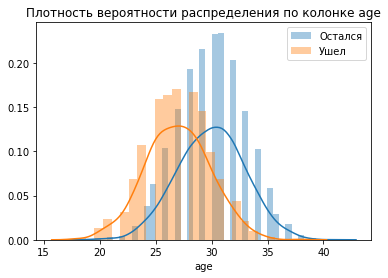

In [10]:
make_graffic(df, 'age')

*Как и на расшифровки средних, мы видим, что график отличается не на много но эти несколько лет на мой взгляд очень важный показатель. Ну а плотность показателей совершенно одинаковая.*

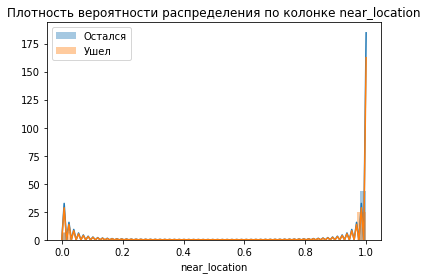

In [11]:
make_graffic(df, 'near_location')

*Показатели по проживанию в непосредсвенной близости имеют очень схожие графики между собой но факт остается люди которые уходят проживают дальше тех кто остается.*

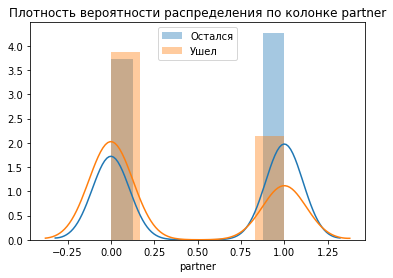

In [12]:
make_graffic(df, 'partner')

*Интересный и важный показатель Людей которые пришли по партнерской программе. Если люди которые пришли не по партнеской программе то те кто пришел по партнерки чаще всего остаются чем уходят*

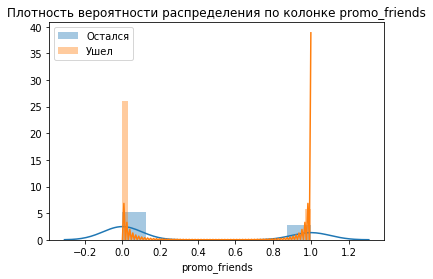

In [13]:
make_graffic(df, 'promo_friends')

*Люди которые пришли сами в разы больше уходят чем те кто пришел по программе "приведи друга". Предположительные причины я уже писал и повторюсь - Есть компания с кем ходить и соревновательный эффект.*

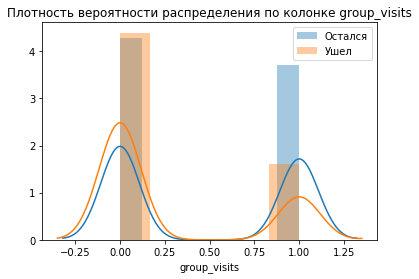

In [14]:
make_graffic(df, 'group_visits')

*Похожий граффик с "партнерской программой". Те кто посещал больше групповых занятий в итоге реже принимают решение не продолжать занятия.*

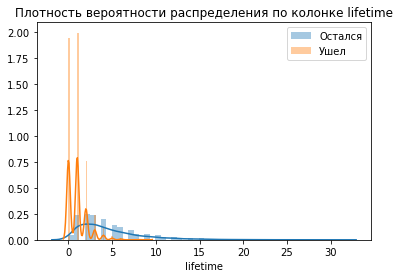

In [15]:
make_graffic(df, 'lifetime')

*Старички занятий уходят реже и за них надо бороться так как другие интересные показатели по тратам в зале у них тоже выше.*

## Корреляционая матрица зависимых показателей

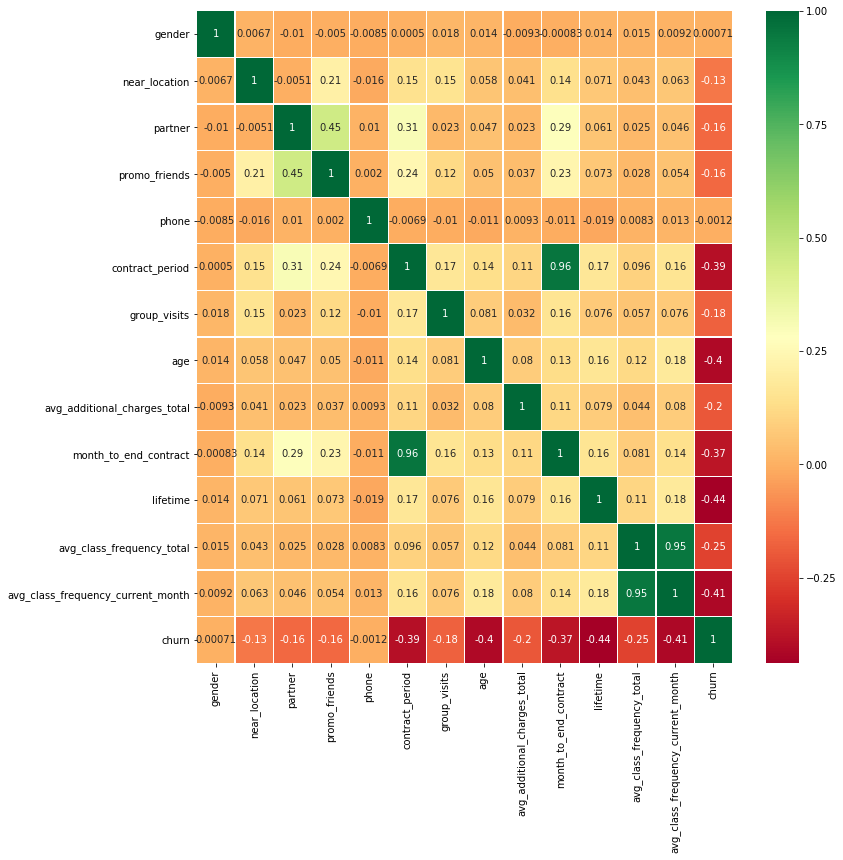

In [16]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

Из показателей матрицы, сильные связи можно заметеить между столбцом "promo_friends" и "partner", что конечно наводит на мысли, что те люди которые пришли по акции и позвали друзей очень ценны для фитнес-клуба. Следующий очень сильный показатель между соколько человек вообще ходит в зал и период сколько он "отзанимался" Это очень очевидно и в пояснение конечно не нужно. 
* из показателя "месяцев до окончания абонемента" и "Партнер" или "акция" можем тоже видеть связь. Это наталкивает меня на мысль, что большие по периоду абонементы покупаются людми которые приходят по той или иной акции.
* Таже показатели "партнер" и "акция" с полем " близость расположения" так хорошо между собой зависят. Залы часто предлагают свои услуши в непосредственной близости от работы. у тут есть инетересны показатель, что человек будет ходить в зал пока работает в этой организации, но показатели все ровно хорошие.
* Инетерсная отрицательная корреляция между столбцами "продлжительность нахождения" и "желанием уйти". Это можно трактовать несколькими способами. Человек приходит просто за определенной целью. Или человек приходит по акционной цене на небольшой срок а дальше не собирается продолжать свой абонемент.
* У тех кто собирается уходить отрицательная корреляция средней частоты посещений в неделю. Не удивительно.

## Соотношение данных между собой

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


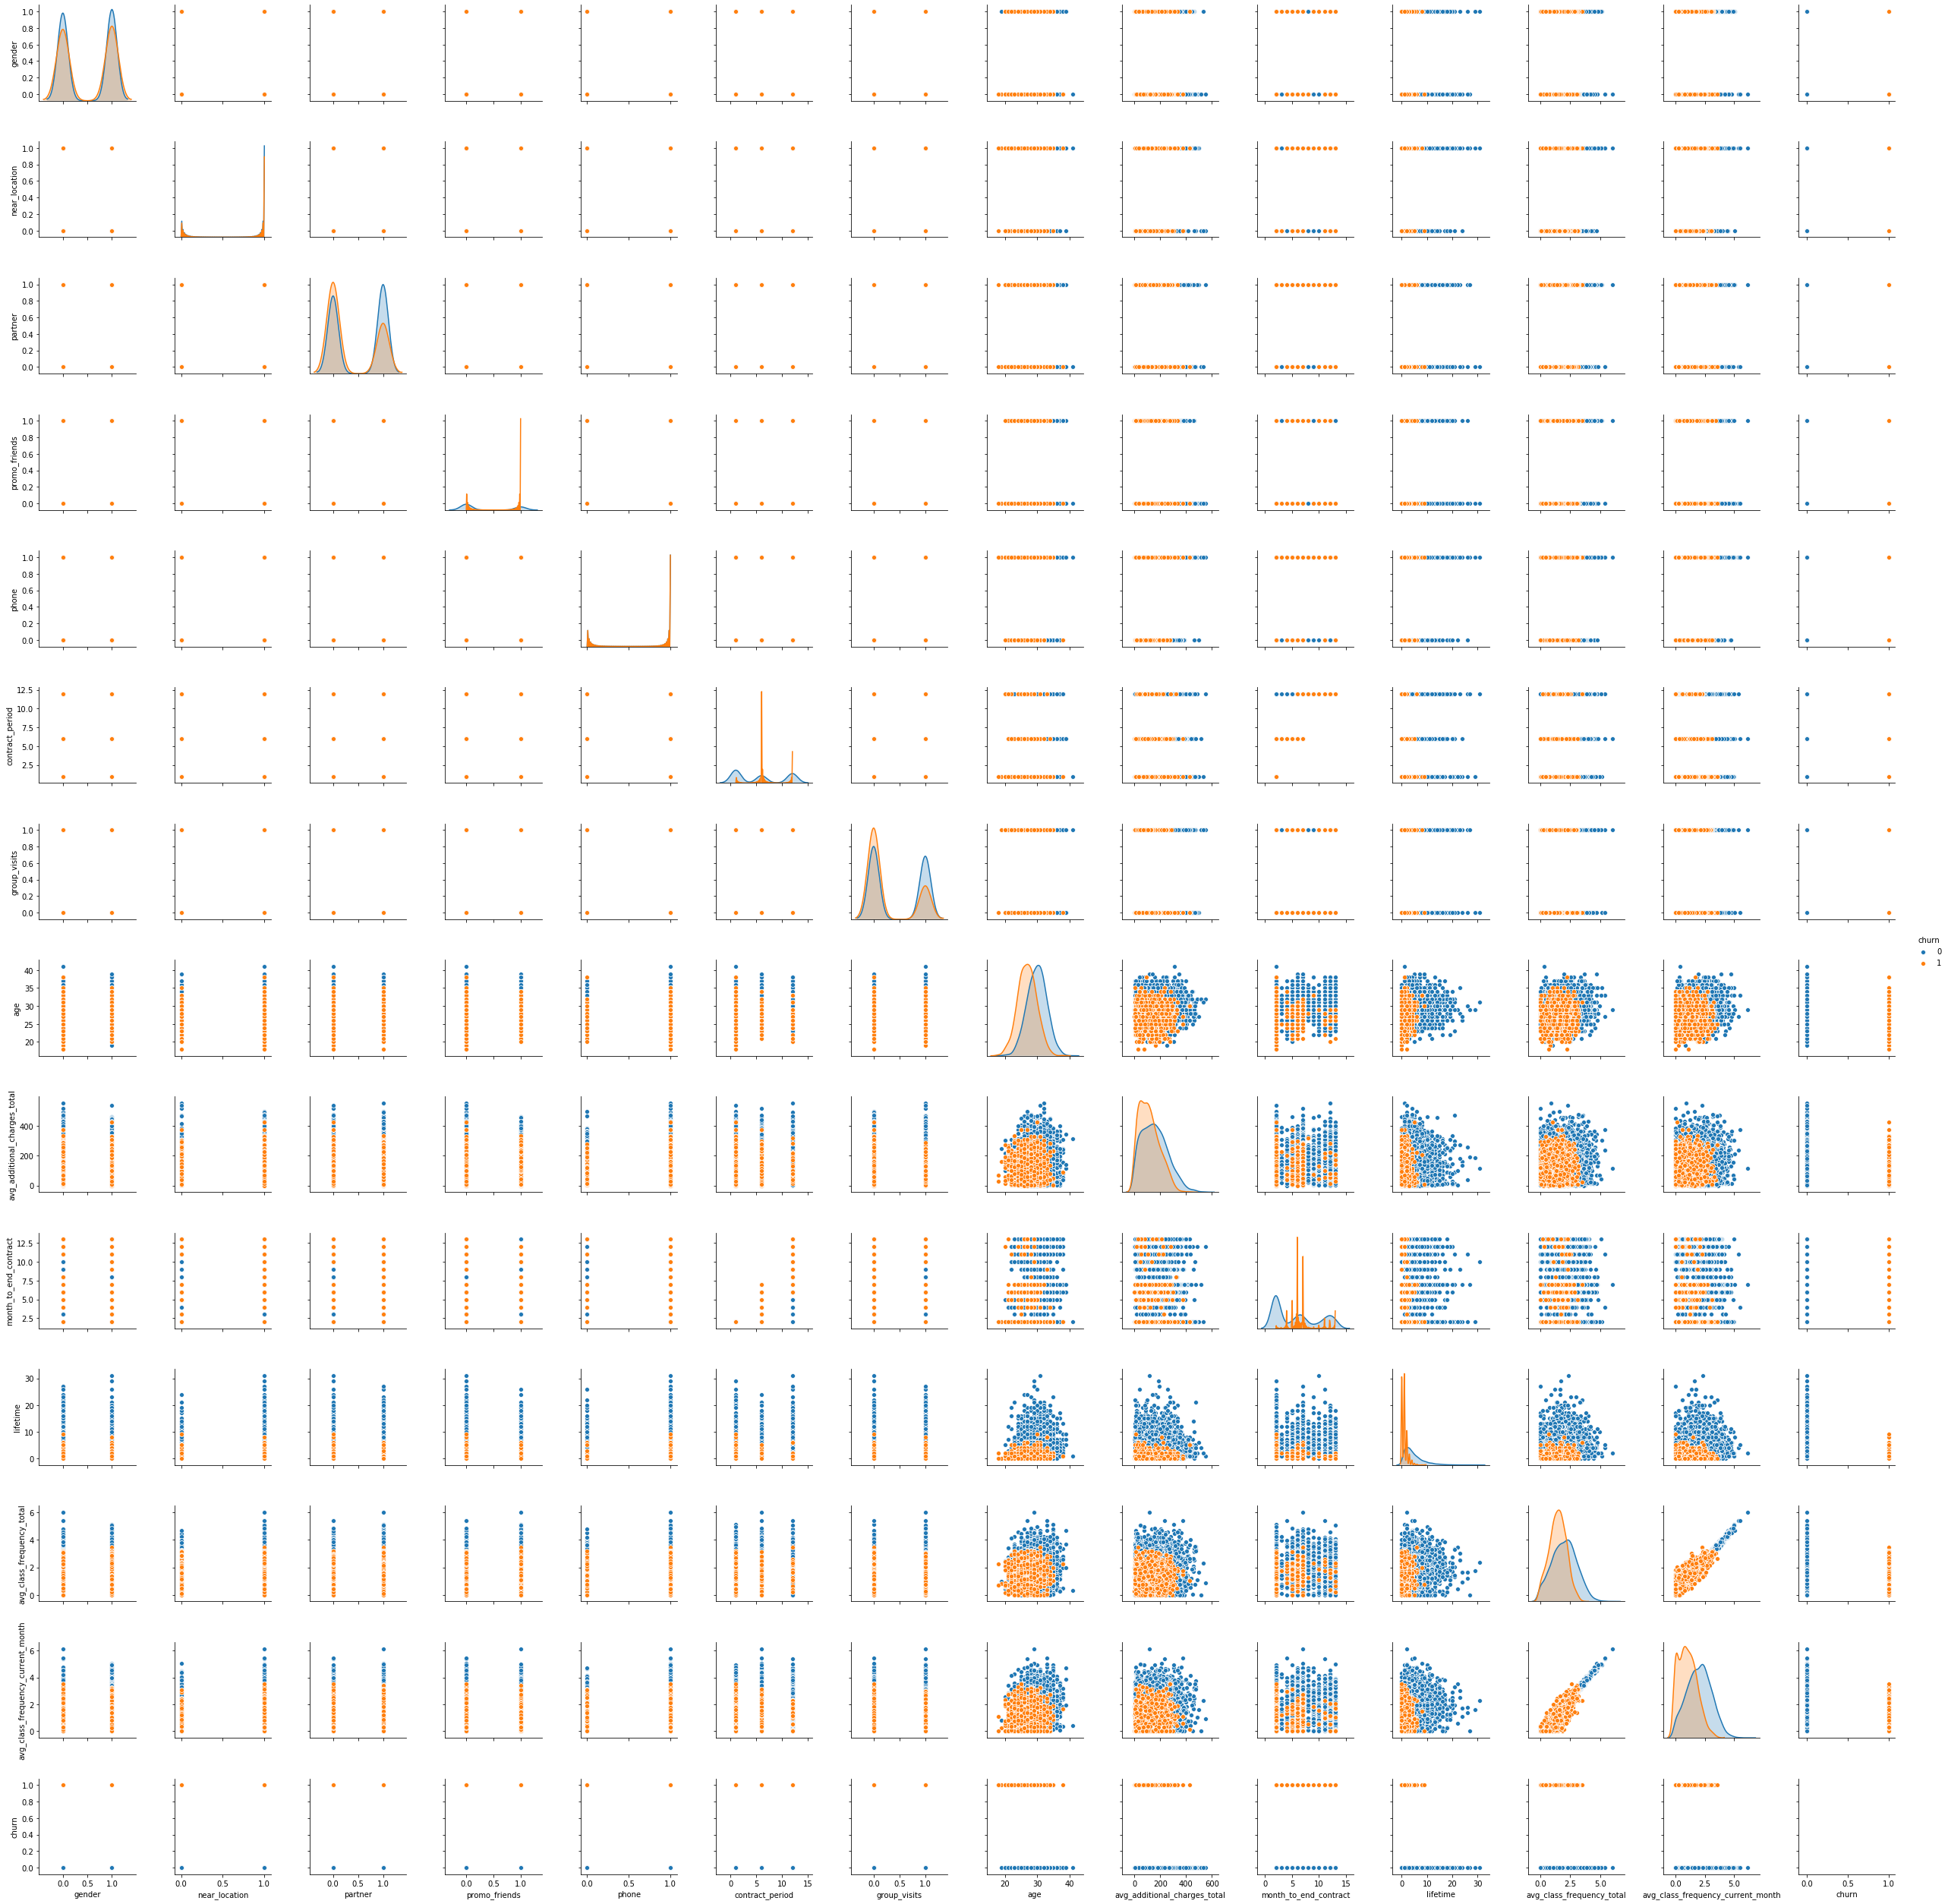

In [17]:
fig = sns.pairplot(data=df, hue='churn')
plt.show()

### Вывод

Датасет имеет размер в 4000 строк и качественно собран. Не имеет выбросов и отсутсвтующих значений, подходит для построения моделей. Данные собраны корректно и имеют валидационную ценность. Выделяются интересные зависимости и даже несколько опровержений расхожему мнению, хотя конечно это данные только одного фитнес центра.

# Построение модели прогнозирования оттока людей

Для того чтобы построить можель разделем датасет на валидационный и тестовый в соотношение 75/25.

In [18]:
# Подготовка и деление двух наборов данных
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=12345)

features_train = df_train.drop(["churn"], axis=1)
target_train = df_train["churn"]

features_valid = df_valid.drop(["churn"], axis=1)
target_valid = df_valid["churn"]

### Модель логистической регрессии

In [19]:
# Логистической регрессия
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

train_predictions = model.predict(features_valid)

accuracy = accuracy_score(target_valid, train_predictions)
recall = recall_score(target_valid, train_predictions)
precision = precision_score(target_valid, train_predictions)

#mse = mean_squared_error(target_valid, precision)
#rmse = mse**0.5

print(f'Метрика качества модели accuracy : {accuracy}')
print(f'Метрика точности модели recall : {recall}')
print(f'Метрика полноты модели precision : {precision}')

Метрика качества модели accuracy : 0.924
Метрика точности модели recall : 0.8282442748091603
Метрика полноты модели precision : 0.875


Модель логистической регнессии показывает хорошие параметры, что не удивительно по тем данным которые были собраны.

### Модель случайного леса

Модель случайного леса я собирал перебором показателя n_estimator в цикле и поском наименьшей ошибки среднеквадратичного отклонения. Разница между 70 и 20 была небольшая(0,29) но при учете, что у нас небольшой объем данных который быстро может обрабатываться я не боюсь за показатель 70.

In [20]:
# Случайный лес
for i_est in range(1, 100, 5):

    model_forest = RandomForestClassifier(random_state=12345,n_estimators=i_est)
    model_forest.fit(features_train,target_train)

    prediction_tree_valid = model_forest.predict(features_valid)

    accuracy = accuracy_score(target_valid, prediction_tree_valid)
    recall = recall_score(target_valid, prediction_tree_valid)
    precision = precision_score(target_valid, prediction_tree_valid)

    mse = mean_squared_error(target_valid, prediction_tree_valid)
    rmse = mse**0.5


    #print(f'показатели для n_estimators равный {i_est}')
    print(f'Метрика качества модели accuracy : {accuracy}')
    print(f'Метрика точности модели recall : {recall}')
    print(f'Метрика полноты модели precision : {precision}')
    print(f'Метрика среднеквадратичного отклонения модели : {rmse}')

Метрика качества модели accuracy : 0.878
Метрика точности модели recall : 0.7900763358778626
Метрика полноты модели precision : 0.7554744525547445
Метрика среднеквадратичного отклонения модели : 0.3492849839314596
Метрика качества модели accuracy : 0.896
Метрика точности модели recall : 0.7480916030534351
Метрика полноты модели precision : 0.8376068376068376
Метрика среднеквадратичного отклонения модели : 0.322490309931942
Метрика качества модели accuracy : 0.909
Метрика точности модели recall : 0.8091603053435115
Метрика полноты модели precision : 0.8379446640316206
Метрика среднеквадратичного отклонения модели : 0.30166206257996714
Метрика качества модели accuracy : 0.904
Метрика точности модели recall : 0.7748091603053435
Метрика полноты модели precision : 0.8458333333333333
Метрика среднеквадратичного отклонения модели : 0.30983866769659335
Метрика качества модели accuracy : 0.909
Метрика точности модели recall : 0.8091603053435115
Метрика полноты модели precision : 0.8379446640316

In [21]:
popular_class = target_valid.value_counts(sort = True).index[0]
y_baseline = np.repeat(popular_class, target_valid.shape)
print(accuracy_score(target_valid, y_baseline))

0.738


In [22]:
tree = DecisionTreeClassifier(max_depth=100, random_state=5)
tree.fit(features_train,target_train)

tree_params = {'max_depth': range(1,100),'max_features': [1, 3, 5, 7, 10]}
tree_grid = GridSearchCV(tree, param_grid = tree_params ,cv=5, n_jobs=2, verbose=True)

In [23]:
tree_grid.fit(features_train, target_train)

Fitting 5 folds for each of 495 candidates, totalling 2475 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  62 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done 1262 tasks      | elapsed:   24.1s
[Parallel(n_jobs=2)]: Done 2475 out of 2475 | elapsed:   37.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=100,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=5,
                                              splitter='best'),
             iid='warn', n_jobs=2,
             param_grid={'max_depth': range(1, 100),
                         'max_features': [1, 3, 5, 7, 10]},
             pre_dispatch='2*n

In [24]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 10}

In [25]:
tree_grid.best_score_

0.8966666666666666

In [26]:
accuracy_score(target_valid, tree_grid.predict(features_valid))

0.901

## Вывод

Между этими моделями нельзя дать однозначный ответ. Если нам достаточно применения этой модели на данной выборке то скорость не самый важный показатель к модели "случайный лес" по показателям она отстает от логистической регрессии но итоговая точность модели выше а отстование небольшое. Но для данной выбоки я думаю нет большой разницы в этих методах, так как есть очень много ярко выраженных зависимостей. На основание метрик лучше себя показала модель логистической регрессии, но это не повод выбирать именно ее.

# Кластеризация пользователей

In [27]:
# удалим основной признак работы моделей
df_drop_char = df.drop(['churn'],axis=1)

In [28]:
# Стандартизируем данные
sc = StandardScaler()
df_sc = sc.fit_transform(df_drop_char)

linked = linkage(df_sc, method = 'ward')

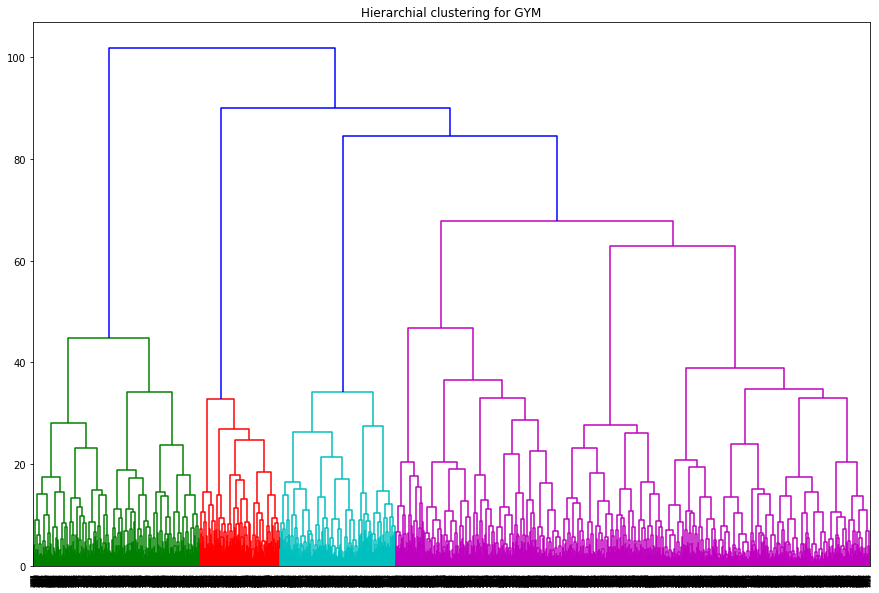

In [29]:
# Построим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

По данным графика можно разделить данные на 5 кластера

In [30]:
# Применим метод кластеризации для всего датасета
km = KMeans(n_clusters = 5,random_state=12345) # задаём число кластеров, равное 4
labels = km.fit_predict(df_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [31]:
# датасет был разделен на 4 кластера
labels.max()

4

In [32]:
# Присваиваем значения кластеров к данным выборки
df['cluster_km'] = labels

In [33]:
# Посмотрим средние показатели людей по кластерам
df.groupby(['cluster_km']).mean().reset_index()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,5.145078,3.940415,1.854211,1.723967,0.266839
1,1,0.486156,0.719055,0.298860,0.018730,1.0,1.918567,0.276873,28.074104,129.487248,2.717427,2.171824,1.227016,0.968634,0.573290
2,2,0.500787,0.949606,0.829921,0.998425,1.0,3.135433,0.447244,29.110236,141.491201,3.634646,3.755906,1.770329,1.669848,0.245669
3,3,0.554556,0.849269,0.263217,0.051744,1.0,2.632171,0.434196,30.017998,159.749030,3.245219,4.764904,2.750063,2.738963,0.088864
4,4,0.500000,0.936195,0.738979,0.479118,1.0,11.825986,0.549884,29.909513,163.847347,11.055684,4.744780,2.000712,1.993018,0.022042


из данной визуализация по кластерам можно опять отметить, что люди которые занимаются не одни, по партнерской программе и акции приведи друга остаются в центре чаще чем те, которые не пользуются этими программами.

In [34]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name,y_name, cluster_name):
    plt.figure(figsize = (5,5))
    sns.scatterplot(df[x_name], df[y_name],
           hue = df[cluster_name], palette = 'Paired'
       )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

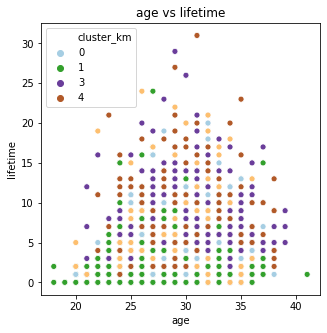

In [35]:
show_clusters_on_plot(df,'age',\
                     'lifetime','cluster_km')

*Кластеры перемешаны и нельзя выделить какой то отдельный*

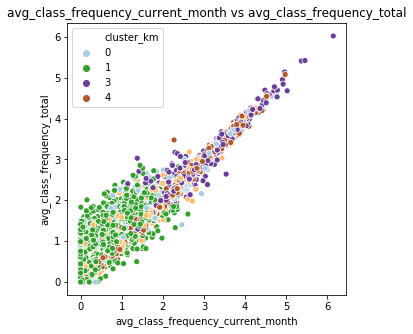

In [36]:
show_clusters_on_plot(df,'avg_class_frequency_current_month',\
                     'avg_class_frequency_total','cluster_km')

*Вот это интересный граффик. Мы видим первую группу как наименее посещаемую зал и в этой группе если говорить на перед наибольшее число отказов на продление абонемента.*

## Процентное соотнешние уходящих людей по кластерам

In [37]:
# Подготовим дата сет для отображения круговый диаграмм
df_gr = df.groupby('cluster_km')['churn'].value_counts()
df_n = df_gr.to_frame()
df_n.columns = ['cnt']
df_n = df_n.reset_index()
df_n = df_n.sort_values(by=list(df_n.columns),axis=0)

In [38]:
def pie_churn(digt):

    df_flt = df_n.query('cluster_km == @digt')
    size = list(df_flt['cnt'])
    print(size)
    colors = ['red', 'pink']
    labels = "остался(ась)", "ушел(а)"
    explode = [0, 0.2]

    plt.pie(size, colors = colors, labels = labels, autopct = '%.f%%', explode = explode, shadow = True)
    plt.legend()
    print(f'Кластер {digt}')
    plt.show()

[283, 103]
Кластер 0


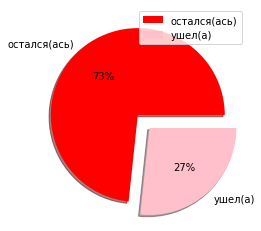

In [39]:
pie_churn(0)

[524, 704]
Кластер 1


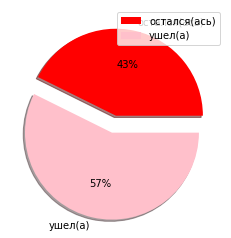

In [40]:
pie_churn(1)

[479, 156]
Кластер 2


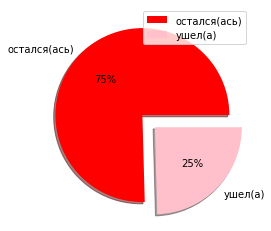

In [41]:
pie_churn(2)

[810, 79]
Кластер 3


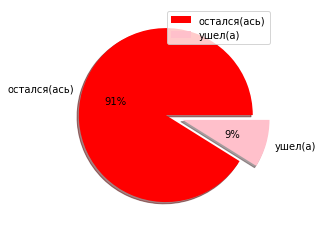

In [42]:
pie_churn(3)

[843, 19]
Кластер 4


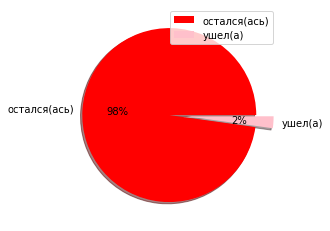

In [43]:
pie_churn(4)

In [44]:
# Посмотрим средние показатели людей по кластерам
df.groupby(['cluster_km']).mean().reset_index()

,cluster_km,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,5.145078,3.940415,1.854211,1.723967,0.266839
1,1,0.486156,0.719055,0.298860,0.018730,1.0,1.918567,0.276873,28.074104,129.487248,2.717427,2.171824,1.227016,0.968634,0.573290
2,2,0.500787,0.949606,0.829921,0.998425,1.0,3.135433,0.447244,29.110236,141.491201,3.634646,3.755906,1.770329,1.669848,0.245669
3,3,0.554556,0.849269,0.263217,0.051744,1.0,2.632171,0.434196,30.017998,159.749030,3.245219,4.764904,2.750063,2.738963,0.088864
4,4,0.500000,0.936195,0.738979,0.479118,1.0,11.825986,0.549884,29.909513,163.847347,11.055684,4.744780,2.000712,1.993018,0.022042


## Вывод

Наибольшее число желающих закрыть свой абонемент находится в группе 1
    * уходит 57% остается 43%
    * 0 - 73% уходит и 27% остается
    * 2 - 75% уходит и 25% остается
    * 3 - 25% уходит и 75% остается
    * 4 - 10% уходит и 90% остается
    
    
Если посмотреть еще раз на все столбцы средних показателей датасета. Можно увидеть и выделить основные показатели которые влияют на то сколько будет заниматься человек в зале. 

    - Парнерка
    - Акция приведи дурга
    - чем старше человек тем больше вероятностью, что он "на долго"
    - Чем чаще и дольше время провождения в зале тем больше вероятность, что он будет продлевать абонемент
    - Выжны посещения групповых занятий
    - Интересный показатель средней выручки от доп. услуг. В группе которая наибольше всего склонна к уходу этот показатель меньше. У кого больше тем лучше себя чувствуют люди.
    
Маркетинговые действия
    
    - делать промо занятия для групповых десциплин (Необходимо, чтобы люди знакомились и поддерживали отношения группой хотябы и в рамках спортзала)
    - нужно увеличить информационную доступности для Акции приведи друга. Об этом можно ненавящево сообщать на стойке ресепшена и высылать уведомления в приложение или на почту.
    - Нужно поощерять при первом знакомстве людей которые в возрасте, чтобы они купили абонемент так как чем старше человек тем он разборчивее и не готов на перемены это касается и сопртивного зала.
    - 